In [2]:
import os
import sys
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from img2vec import rgb2emb


### Set random seed for reproducibility

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

### Load data

In [4]:
data_dir = os.path.join('..', '..', 'data')
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
val_data = pd.read_csv(os.path.join(data_dir, 'val.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))

### Print dataset information

In [5]:
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 11856
Validation set size: 2964
Test set size: 3731


### Check if images exist and filter

In [6]:
def construct_img_path(row):
    return os.path.join(data_dir, 'faces', row['user_id'], 
                      f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}")

train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)

train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

# Filter to include only rows where images exist
train_data = train_data[train_data['img_exists'] == True]
val_data = val_data[val_data['img_exists'] == True]
test_data = test_data[test_data['img_exists'] == True]

Encode labels

In [7]:
if os.path.exists('age_encoder.pkl') and os.path.exists('gender_encoder.pkl'):
    age_encoder = joblib.load('age_encoder.pkl')
    gender_encoder = joblib.load('gender_encoder.pkl')
    print("Age and gender encoders loaded successfully.")
    
    # Add these lines to encode train data when loading existing encoders
    train_data['age_encoded'] = age_encoder.transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.transform(train_data['gender'])
else:
    # Remove rare classes
    age_counts = train_data['age'].value_counts()
    gender_counts = train_data['gender'].value_counts()
    rare_ages = age_counts[age_counts < 5].index.tolist()
    rare_genders = gender_counts[gender_counts < 5].index.tolist()
    
    # Filter data
    train_data = train_data[~train_data['age'].isin(rare_ages) & ~train_data['gender'].isin(rare_genders)]
    
    # Create encoders
    age_encoder = LabelEncoder()
    gender_encoder = LabelEncoder()
    train_data['age_encoded'] = age_encoder.fit_transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.fit_transform(train_data['gender'])
    
    # Save encoders
    joblib.dump(age_encoder, 'age_encoder.pkl')
    joblib.dump(gender_encoder, 'gender_encoder.pkl')
    print("Encoders created and saved.")

# Filter validation and test data to include only seen classes
val_data = val_data[val_data['age'].isin(age_encoder.classes_)]
val_data = val_data[val_data['gender'].isin(gender_encoder.classes_)]
test_data = test_data[test_data['age'].isin(age_encoder.classes_)]
test_data = test_data[test_data['gender'].isin(gender_encoder.classes_)]

# Encode the labels
val_data['age_encoded'] = age_encoder.transform(val_data['age'])
val_data['gender_encoded'] = gender_encoder.transform(val_data['gender'])
test_data['age_encoded'] = age_encoder.transform(test_data['age'])
test_data['gender_encoded'] = gender_encoder.transform(test_data['gender'])

num_age_classes = len(age_encoder.classes_)
num_gender_classes = len(gender_encoder.classes_)
print(f"Age classes: {age_encoder.classes_}")
print(f"Gender classes: {gender_encoder.classes_}")

Age and gender encoders loaded successfully.
Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']
Gender classes: ['f' 'm' 'u']


### Define function that processes features in batches and stores them to avoid recomputation

In [8]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}")
        batch_features = rgb2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [9]:
if not os.path.exists('train_features.npy'):
    train_features = preprocess_and_save_features(train_data['img_path'].tolist(), 'train_features.npy')
    val_features = preprocess_and_save_features(val_data['img_path'].tolist(), 'val_features.npy')
    test_features = preprocess_and_save_features(test_data['img_path'].tolist(), 'test_features.npy')
else:
    train_features = np.load('train_features.npy')
    val_features = np.load('val_features.npy')
    test_features = np.load('test_features.npy')

### Standardize features

In [10]:
if os.path.exists('feature_scaler.pkl'):
    scaler = joblib.load('feature_scaler.pkl')
    print("Feature scaler loaded successfully.")
else:
    scaler = StandardScaler()
    scaler.fit(train_features)
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("Feature scaler created and saved.")

train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

Feature scaler loaded successfully.


### Define LSTM model

In [11]:
def create_age_model(input_dim, num_classes):
    input_layer = Input(shape=(input_dim,))
    
    # First dense block
    x = Dense(512, activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Second dense block
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Third dense block
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Define improved feed-forward neural network for gender classification
def create_gender_model(input_dim, num_classes):
    input_layer = Input(shape=(input_dim,))
    
    # First dense block
    x = Dense(256, activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Second dense block
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Create models
input_dim = train_features_scaled.shape[1]
age_model = create_age_model(input_dim, num_age_classes)
gender_model = create_gender_model(input_dim, num_gender_classes)

# Print model summaries
print("Age Model Summary:")
age_model.summary()
print("\nGender Model Summary:")
gender_model.summary()

# Define callbacks with improved parameters
age_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,         # More patient than before
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    ),
    ModelCheckpoint(
        'best_ffnn_age_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

gender_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    ),
    ModelCheckpoint(
        'best_ffnn_gender_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

Age Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217,928 (4.65 MB)

 Trainable params: 1,216,136 (4.64 MB)

 Non-trainable params: 1,792 (7.00 KB)


Gender Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 559,363 (2.13 MB)

 Trainable params: 558,595 (2.13 MB)

 Non-trainable params: 768 (3.00 KB)

### Compute class weights and get labels

In [12]:
train_age_labels = train_data['age_encoded'].values
train_gender_labels = train_data['gender_encoded'].values
val_age_labels = val_data['age_encoded'].values
val_gender_labels = val_data['gender_encoded'].values

age_weights = compute_class_weight('balanced', classes=np.unique(train_age_labels), y=train_age_labels)
gender_weights = compute_class_weight('balanced', classes=np.unique(train_gender_labels), y=train_gender_labels)


### Train models

In [13]:
print("Training the age model...")
age_history = age_model.fit(
    train_features_scaled,
    train_age_labels,
    validation_data=(val_features_scaled, val_age_labels),
    epochs=50,               # More epochs with early stopping
    batch_size=32,           # Smaller batch size
    callbacks=age_callbacks,
    class_weight=dict(enumerate(age_weights))
)

# Train gender model
print("Training the gender model...")
gender_history = gender_model.fit(
    train_features_scaled,
    train_gender_labels,
    validation_data=(val_features_scaled, val_gender_labels),
    epochs=50,
    batch_size=32,
    callbacks=gender_callbacks,
    class_weight=dict(enumerate(gender_weights))
)

Training the age model...
Epoch 1/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2820 - loss: 2.1782
Epoch 1: val_loss improved from inf to 1.29741, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.2821 - loss: 2.1774 - val_accuracy: 0.4841 - val_loss: 1.2974 - learning_rate: 5.0000e-04
Epoch 2/50
369/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4378 - loss: 1.4257
Epoch 2: val_loss improved from 1.29741 to 1.16732, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4379 - loss: 1.4253 - val_accuracy: 0.5388 - val_loss: 1.1673 - learning_rate: 5.0000e-04
Epoch 3/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5078 - loss: 1.1925
Epoch 3: val_loss improved from 1.16732 to 1.09517, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5079 - loss: 1.1924 - val_accuracy: 0.5644 - val_loss: 1.0952 - learning_rate: 5.0000e-04
Epoch 4/50
368/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5659 - loss: 1.0088
Epoch 4: val_loss improved from 1.09517 to 1.02351, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5660 - loss: 1.0085 - val_accuracy: 0.6002 - val_loss: 1.0235 - learning_rate: 5.0000e-04
Epoch 5/50
369/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6180 - loss: 0.8746
Epoch 5: val_loss improved from 1.02351 to 0.99401, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6180 - loss: 0.8744 - val_accuracy: 0.6086 - val_loss: 0.9940 - learning_rate: 5.0000e-04
Epoch 6/50
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6552 - loss: 0.7757
Epoch 6: val_loss improved from 0.99401 to 0.99323, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6553 - loss: 0.7756 - val_accuracy: 0.6167 - val_loss: 0.9932 - learning_rate: 5.0000e-04
Epoch 7/50
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7130 - loss: 0.6388
Epoch 7: val_loss improved from 0.99323 to 0.97342, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7129 - loss: 0.6388 - val_accuracy: 0.6407 - val_loss: 0.9734 - learning_rate: 5.0000e-04
Epoch 8/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7429 - loss: 0.5584
Epoch 8: val_loss improved from 0.97342 to 0.97112, saving model to best_ffnn_age_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7429 - loss: 0.5583 - val_accuracy: 0.6609 - val_loss: 0.9711 - learning_rate: 5.0000e-04
Epoch 9/50
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7678 - loss: 0.5055
Epoch 9: val_loss did not improve from 0.97112
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7679 - loss: 0.5054 - val_accuracy: 0.6525 - val_loss: 0.9809 - learning_rate: 5.0000e-04
Epoch 10/50
369/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7913 - loss: 0.4572
Epoch 10: val_loss did not improve from 0.97112
371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7913 - loss: 0.4570 - val_accuracy: 0.6667 - val_loss: 1.0035 - learning_rate: 5.0000e-04
Epoch 11/50
368/371 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8116 - loss: 0.3862
Epoch 11: val_loss did not improve from 0.97112
371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8116 - loss: 0.3861 - val_accuracy: 0.6751 - val_loss: 0.9865 - learning_rate: 5.0000e-04
Epoch 12/5

371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6401 - loss: 0.8208 - val_accuracy: 0.8242 - val_loss: 0.4640 - learning_rate: 5.0000e-04
Epoch 2/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8148 - loss: 0.4101
Epoch 2: val_loss improved from 0.46405 to 0.39939, saving model to best_ffnn_gender_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8148 - loss: 0.4100 - val_accuracy: 0.8546 - val_loss: 0.3994 - learning_rate: 5.0000e-04
Epoch 3/50
364/371 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8540 - loss: 0.3161
Epoch 3: val_loss improved from 0.39939 to 0.37527, saving model to best_ffnn_gender_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8541 - loss: 0.3157 - val_accuracy: 0.8593 - val_loss: 0.3753 - learning_rate: 5.0000e-04
Epoch 4/50
364/371 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8928 - loss: 0.2412
Epoch 4: val_loss improved from 0.37527 to 0.31151, saving model to best_ffnn_gender_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8928 - loss: 0.2411 - val_accuracy: 0.8806 - val_loss: 0.3115 - learning_rate: 5.0000e-04
Epoch 5/50
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9141 - loss: 0.1898
Epoch 5: val_loss did not improve from 0.31151
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9141 - loss: 0.1898 - val_accuracy: 0.8850 - val_loss: 0.3320 - learning_rate: 5.0000e-04
Epoch 6/50
368/371 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9287 - loss: 0.1698
Epoch 6: val_loss did not improve from 0.31151
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9287 - loss: 0.1697 - val_accuracy: 0.8850 - val_loss: 0.3275 - learning_rate: 5.0000e-04
Epoch 7/50
368/371 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9407 - loss: 0.1258
Epoch 7: val_loss did not improve from 0.31151
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9407 - loss: 0.1257 - val_accuracy: 0.8920 - val_loss: 0.3187 - learning_rate: 5.0000e-04
Epoch 8/50
369/371 ━━

### Save the model

In [14]:
age_model.save('ffnn_age_model.h5')
gender_model.save('ffnn_gender_model.h5')

### Evaluate the model

In [18]:
print("\nEvaluating models on test set...")

# Convert pandas Series to NumPy arrays
test_age_labels = np.array(test_data['age_encoded'].values)
test_gender_labels = np.array(test_data['gender_encoded'].values)

# Check shapes to ensure compatibility
print(f"test_features_scaled shape: {test_features_scaled.shape}")
print(f"test_age_labels shape: {test_age_labels.shape}")

# Now evaluate with properly formatted arrays
age_loss, age_acc = age_model.evaluate(test_features_scaled, test_age_labels)
gender_loss, gender_acc = gender_model.evaluate(test_features_scaled, test_gender_labels)

print(f"Age Model - Test Loss: {age_loss:.4f}, Test Accuracy: {age_acc:.4f}")
print(f"Gender Model - Test Loss: {gender_loss:.4f}, Test Accuracy: {gender_acc:.4f}")

# Make predictions
age_preds = np.argmax(age_model.predict(test_features_scaled), axis=1)
gender_preds = np.argmax(gender_model.predict(test_features_scaled), axis=1)

# Calculate combined accuracy (both predictions correct)
correct_both = np.logical_and(
    age_preds == test_age_labels,
    gender_preds == test_gender_labels
)
combined_accuracy = np.mean(correct_both)
print(f"Combined Accuracy (both correct): {combined_accuracy:.4f}")


Evaluating models on test set...
test_features_scaled shape: (3731, 2048)
test_age_labels shape: (3731,)
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3963 - loss: 1.8048
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8228 - loss: 0.4818
Age Model - Test Loss: 1.8691, Test Accuracy: 0.3787
Gender Model - Test Loss: 0.5208, Test Accuracy: 0.8129
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Combined Accuracy (both correct): 0.3066


### Generate classification reports

In [ ]:
print("\nAge Classification Report:")
print(classification_report(
    test_data['age_encoded'], 
    age_preds, 
    target_names=age_encoder.classes_
))

print("\nGender Classification Report:")
print(classification_report(
    test_data['gender_encoded'], 
    gender_preds, 
    target_names=gender_encoder.classes_
))


Age Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.79      0.62      0.69       483
    (15, 20)       0.12      0.26      0.16       227
    (25, 32)       0.46      0.24      0.31      1036
    (38, 43)       0.22      0.25      0.23       543
      (4, 6)       0.47      0.43      0.45       570
    (48, 53)       0.15      0.23      0.18       258
   (60, 100)       0.35      0.29      0.32       274
     (8, 23)       0.18      0.28      0.22       340

    accuracy                           0.33      3731
   macro avg       0.34      0.33      0.32      3731
weighted avg       0.39      0.33      0.35      3731


Gender Classification Report:
              precision    recall  f1-score   support

           f       0.80      0.72      0.76      1848
           m       0.72      0.80      0.76      1597
           u       0.70      0.74      0.72       286

    accuracy                           0.76      3731
   macro avg      

### Plot training history

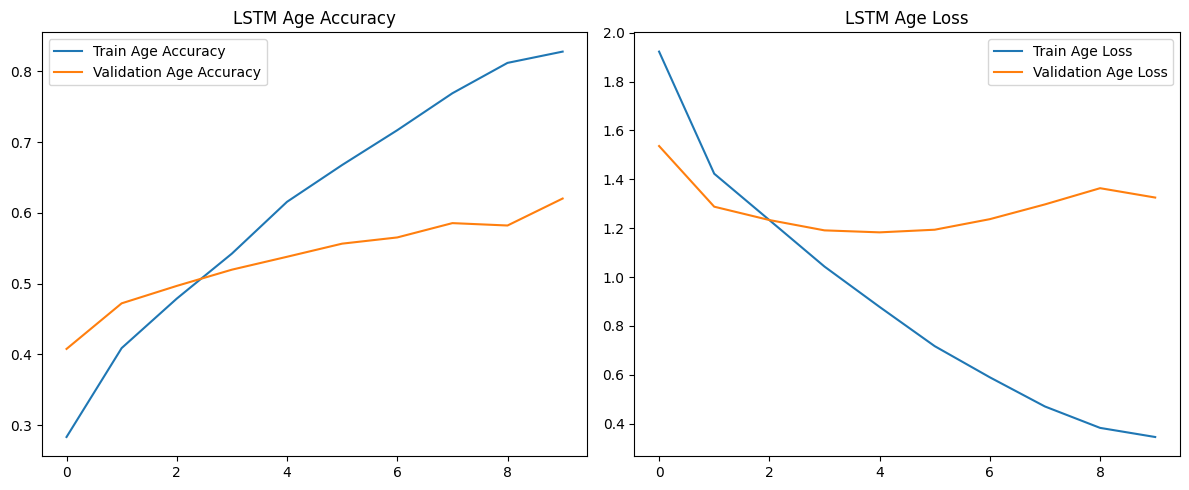

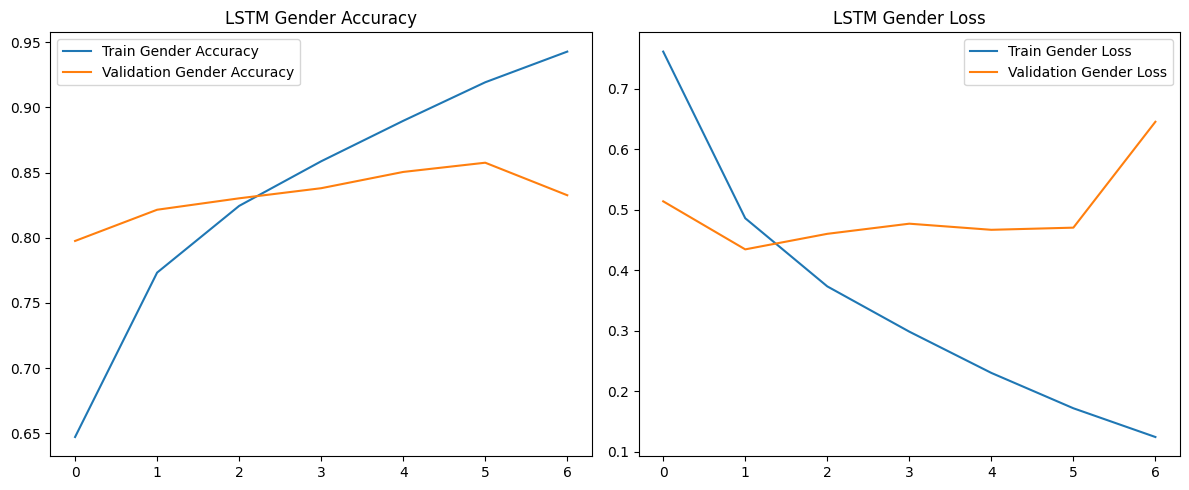

In [ ]:

# Plot training history for age model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(age_history.history['accuracy'])
plt.plot(age_history.history['val_accuracy'])
plt.title('Age Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(age_history.history['loss'])
plt.plot(age_history.history['val_loss'])
plt.title('Age Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('age_model_history.png')
plt.show()

# Plot training history for gender model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(gender_history.history['accuracy'])
plt.plot(gender_history.history['val_accuracy'])
plt.title('Gender Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(gender_history.history['loss'])
plt.plot(gender_history.history['val_loss'])
plt.title('Gender Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('gender_model_history.png')
plt.show()


# Plot confusion matrices
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_data['age_encoded'], age_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=age_encoder.classes_,
            yticklabels=age_encoder.classes_)
plt.title('Age Prediction Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('age_confusion_matrix.png')
plt.show()

plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_data['gender_encoded'], gender_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=gender_encoder.classes_,
            yticklabels=gender_encoder.classes_)
plt.title('Gender Prediction Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('gender_confusion_matrix.png')
plt.show()



### Example of how to load the model and use it for prediction

In [ ]:
def predict_age_and_gender(image_path):
    """
    Load pre-trained feed-forward neural network models and predict age and gender from an image.
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        tuple: (age_range, gender) as strings
    """
    import numpy as np
    import os
    import joblib
    from tensorflow.keras.models import load_model
    from img2vec import rgb2emb
    
    # Check if the image exists
    if not os.path.exists(image_path):
        return "Error: Image not found"
    
    # Load the models
    try:
        age_model = load_model('ffnn_age_model.h5')
        gender_model = load_model('ffnn_gender_model.h5')
    except Exception as e:
        return f"Error loading models: {str(e)}"
    
    # Load the encoders
    try:
        age_encoder = joblib.load('age_encoder.pkl')
        gender_encoder = joblib.load('gender_encoder.pkl')
        scaler = joblib.load('feature_scaler.pkl')
    except Exception as e:
        return f"Error loading encoders: {str(e)}"
    
    # Extract features from the image
    try:
        # Convert to batch format (list with single image)
        features = rgb2emb([image_path])
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        # No need to reshape for feed-forward network
        
        # Make predictions
        age_pred = np.argmax(age_model.predict(features_scaled), axis=1)[0]
        gender_pred = np.argmax(gender_model.predict(features_scaled), axis=1)[0]
        
        # Convert numerical predictions to original labels
        age_range = age_encoder.inverse_transform([age_pred])[0]
        gender = gender_encoder.inverse_transform([gender_pred])[0]
        
        return (age_range, gender)
    
    except Exception as e:
        return f"Error during prediction: {str(e)}"

# Example usage:
age_range, gender = predict_age_and_gender("../../img.jpg")
print(f"Predicted Age Range: {age_range}")
print(f"Predicted Gender: {gender}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Predicted Age Range: (4, 6)
Predicted Gender: m
